## RT-DETR Test
RT-DETR, short for "Real-Time DEtection TRansformer", is a computer vision model developed by Peking University and Baidu. In their paper, "DETRs Beat YOLOs on Real-time Object Detection" the authors claim that RT-DETR can outperform YOLO models in object detection, both in terms of speed and accuracy.

### Install dependencies

In [1]:
import os
HOME = os.getcwd()
print(HOME)

!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"
!pip install -q supervision
!pip install -q pycocotools
!pip install pycocotools
!pip install faster-coco-eval
!pip install torchmetrics[detection]

/home/cjs/Documents/Probe-Detection-Using-Deep-Learning/notebook
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Imports

In [2]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision


2025-01-07 16:47:18.770685: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 16:47:18.776732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736264838.785212   70011 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736264838.787687   70011 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 16:47:18.797311: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# @title Load model

CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)
use_fast=True

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Import Data

In [4]:
HOME = os.getcwd()
print(f"Current working directory: {HOME}")

datasets_path = os.path.join(HOME, 'data/probe_preprocessed_RT-DETR')
os.makedirs(datasets_path, exist_ok=True)


# Change directory to datasets (if needed)
os.chdir(datasets_path)
print(f"Dataset directory: {os.getcwd()}")


Current working directory: /home/cjs/Documents/Probe-Detection-Using-Deep-Learning/notebook
Dataset directory: /home/cjs/Documents/Probe-Detection-Using-Deep-Learning/notebook/data/probe_preprocessed_RT-DETR


In [6]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{datasets_path}/train",
    annotations_path=f"{datasets_path}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{datasets_path}/valid",
    annotations_path=f"{datasets_path}/valid/_annotations.coco.json",
)
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{datasets_path}/test",
    annotations_path=f"{datasets_path}/test/_annotations.coco.json",
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
print(f"Number of test images: {len(ds_test)}")

Number of training images: 648
Number of validation images: 61
Number of test images: 31


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBox

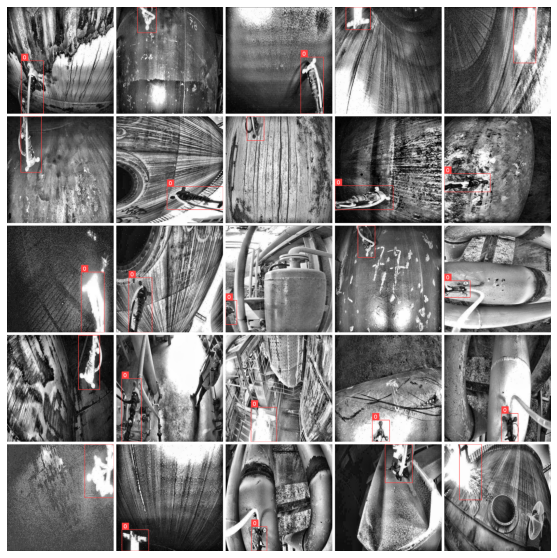

In [7]:
# @title Display dataset sample

GRID_SIZE = 5

def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

annotated_images = []
for i in range(GRID_SIZE * GRID_SIZE):
    _, image, annotations = ds_train[i]
    annotated_image = annotate(image, annotations, ds_train.classes)
    annotated_images.append(annotated_image)

grid = sv.create_tiles(
    annotated_images,
    grid_size=(GRID_SIZE, GRID_SIZE),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE
)
sv.plot_image(grid, size=(10, 10))

### Preprocess the data

To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model. [AutoImageProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoImageProcessor) takes care of processing image data to create `pixel_values`, `pixel_mask`, and `labels` that a DETR model can train with. The image processor has some attributes that you won't have to worry about:

- `image_mean = [0.485, 0.456, 0.406 ]`
- `image_std = [0.229, 0.224, 0.225]`

These are the mean and standard deviation used to normalize images during the model pre-training. These values are crucial to replicate when doing inference or finetuning a pre-trained image model.

Instantiate the image processor from the same checkpoint as the model you want to finetune.

In [8]:
IMAGE_SIZE = 480

processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

Before passing the images to the `processor`, apply two preprocessing transformations to the dataset:

- Augmenting images
- Reformatting annotations to meet RT-DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library. Here we use [Albumentations](https://albumentations.ai/docs/). This library ensures that transformations affect the image and update the bounding boxes accordingly.

In [9]:
train_augmentation_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


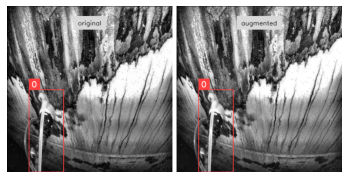

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


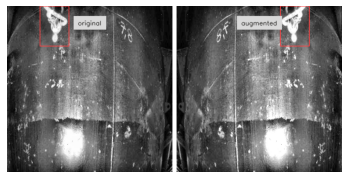

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


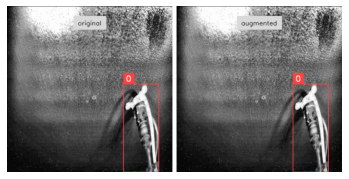

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


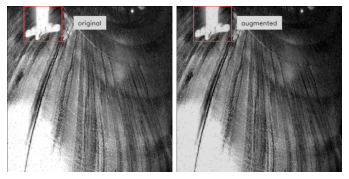

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


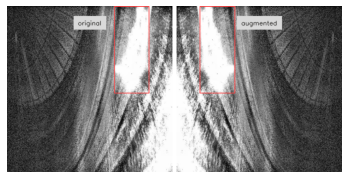

In [10]:
# @title Visualize some augmented images

IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    _, image, annotations = ds_train[i]

    output = train_augmentation_and_transform(
        image=image,
        bboxes=annotations.xyxy,
        category=annotations.class_id
    )

    augmented_image = output["image"]
    augmented_annotations = replace(
        annotations,
        xyxy=np.array(output["bboxes"]),
        class_id=np.array(output["category"])
    )

    annotated_images = [
        annotate(image, annotations, ds_train.classes),
        annotate(augmented_image, augmented_annotations, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['original', 'augmented'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [11]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform
    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

Now you can combine the image and annotation transformations to use on a batch of examples:

In [12]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)
pytorch_dataset_test = PyTorchDetectionDataset(
    ds_test, processor, transform=valid_transform)

pytorch_dataset_train[15]

{'pixel_values': tensor([[[0.0118, 0.0157, 0.0314,  ..., 0.0275, 0.0275, 0.0275],
          [0.0235, 0.0196, 0.0510,  ..., 0.0431, 0.0431, 0.0431],
          [0.0392, 0.0667, 0.1529,  ..., 0.0510, 0.0510, 0.0510],
          ...,
          [0.4902, 0.5451, 0.4118,  ..., 0.0157, 0.0157, 0.0118],
          [0.4941, 0.5137, 0.3216,  ..., 0.0157, 0.0157, 0.0118],
          [0.4863, 0.4824, 0.2588,  ..., 0.0157, 0.0157, 0.0118]],
 
         [[0.0118, 0.0157, 0.0314,  ..., 0.0275, 0.0275, 0.0275],
          [0.0235, 0.0196, 0.0510,  ..., 0.0431, 0.0431, 0.0431],
          [0.0392, 0.0667, 0.1529,  ..., 0.0510, 0.0510, 0.0510],
          ...,
          [0.4902, 0.5451, 0.4118,  ..., 0.0157, 0.0157, 0.0118],
          [0.4941, 0.5137, 0.3216,  ..., 0.0157, 0.0157, 0.0118],
          [0.4863, 0.4824, 0.2588,  ..., 0.0157, 0.0157, 0.0118]],
 
         [[0.0118, 0.0157, 0.0314,  ..., 0.0275, 0.0275, 0.0275],
          [0.0235, 0.0196, 0.0510,  ..., 0.0431, 0.0431, 0.0431],
          [0.0392, 0.066

You have successfully augmented the images and prepared their annotations. In the final step, create a custom collate_fn to batch images together.

In [13]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

## Preparing function to compute mAP

In [19]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        print(metrics)
        classes = metrics.pop("classes", None)  # Use None if "classes" is not present
        map_per_class = metrics.pop("map_per_class", [])  # Default to an empty list
        mar_100_per_class = metrics.pop("mar_100_per_class", [])  # Default to an empty list

        if classes is not None:
            for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
                class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
                metrics[f"map_{class_name}"] = class_map
                metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

## Training the detection model

You have done most of the heavy lifting in the previous sections, so now you are ready to train your model! The images in this dataset are still quite large, even after resizing. This means that finetuning this model will require at least one GPU.

Training involves the following steps:

- Load the model with [`AutoModelForObjectDetection`](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
- Define your training hyperparameters in [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
- Pass the training arguments to [`Trainer`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
- Call [`train()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the `label2id` and `id2label` maps that you created earlier from the dataset's metadata. Additionally, we specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [15]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.

In the [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) use `output_dir` to specify where to save your model, then configure hyperparameters as you see fit. For `num_train_epochs=10` training will take about 15 minutes in Google Colab T4 GPU, increase the number of epoch to get better results.

Important notes:

- Do not remove unused columns because this will drop the image column. Without the image column, you can't create `pixel_values`. For this reason, set `remove_unused_columns` to `False`.
- Set `eval_do_concat_batches=False` to get proper evaluation results. Images have different number of target boxes, if batches are concatenated we will not be able to determine which boxes belongs to particular image.

In [20]:
training_args = TrainingArguments(
    output_dir=f"{datasets_path}-finetune",
    num_train_epochs=50,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=16,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)

Finally, bring everything together, and call [`train()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
















































                                                 
                                          


                                    

  2%|▏         | 41/2050 [11:28<07:24,  4.52it/s]






{'map': tensor(0.0024), 'map_50': tensor(0.0072), 'map_75': tensor(0.0004), 'map_small': tensor(-1.), 'map_medium': tensor(0.0216), 'map_large': tensor(0.0104), 'mar_1': tensor(0.0098), 'mar_10': tensor(0.0459), 'mar_100': tensor(0.2459), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.2889), 'mar_large': tensor(0.2385), 'map_per_class': tensor([-1.0000,  0.0024]), 'mar_100_per_class': tensor([-1.0000,  0.2459])}
{'eval_loss': 154.43194580078125, 'eval_map': 0.0024, 'eval_map_50': 0.0072, 'eval_map_75': 0.0004, 'eval_map_small': -1.0, 'eval_map_medium': 0.0216, 'eval_map_large': 0.0104, 'eval_mar_1': 0.0098, 'eval_mar_10': 0.0459, 'eval_mar_100': 0.2459, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.2889, 'eval_mar_large': 0.2385, 'eval_runtime': 3.8828, 'eval_samples_per_second': 15.71, 'eval_steps_per_second': 2.06, 'epoch': 1.0}

















































                                                 
                                          

                                           


  2%|▏         | 41/2050 [11:43<07:24,  4.52it/s]






{'map': tensor(0.0189), 'map_50': tensor(0.0308), 'map_75': tensor(0.0181), 'map_small': tensor(-1.), 'map_medium': tensor(0.1118), 'map_large': tensor(0.0855), 'mar_1': tensor(0.0459), 'mar_10': tensor(0.2148), 'mar_100': tensor(0.4869), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.4556), 'mar_large': tensor(0.4923), 'map_per_class': tensor([-1.0000,  0.0189]), 'mar_100_per_class': tensor([-1.0000,  0.4869])}
{'eval_loss': 45.964752197265625, 'eval_map': 0.0189, 'eval_map_50': 0.0308, 'eval_map_75': 0.0181, 'eval_map_small': -1.0, 'eval_map_medium': 0.1118, 'eval_map_large': 0.0855, 'eval_mar_1': 0.0459, 'eval_mar_10': 0.2148, 'eval_mar_100': 0.4869, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.4556, 'eval_mar_large': 0.4923, 'eval_runtime': 3.5135, 'eval_samples_per_second': 17.362, 'eval_steps_per_second': 2.277, 'epoch': 2.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [11:57<07:24,  4.52it/s]






{'map': tensor(0.0560), 'map_50': tensor(0.0965), 'map_75': tensor(0.0568), 'map_small': tensor(-1.), 'map_medium': tensor(0.1439), 'map_large': tensor(0.2378), 'mar_1': tensor(0.1262), 'mar_10': tensor(0.5459), 'mar_100': tensor(0.7656), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.5444), 'mar_large': tensor(0.8038), 'map_per_class': tensor([-1.0000,  0.0560]), 'mar_100_per_class': tensor([-1.0000,  0.7656])}
{'eval_loss': 30.15377426147461, 'eval_map': 0.056, 'eval_map_50': 0.0965, 'eval_map_75': 0.0568, 'eval_map_small': -1.0, 'eval_map_medium': 0.1439, 'eval_map_large': 0.2378, 'eval_mar_1': 0.1262, 'eval_mar_10': 0.5459, 'eval_mar_100': 0.7656, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.5444, 'eval_mar_large': 0.8038, 'eval_runtime': 3.2423, 'eval_samples_per_second': 18.814, 'eval_steps_per_second': 2.467, 'epoch': 3.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [12:10<07:24,  4.52it/s]






{'map': tensor(0.2832), 'map_50': tensor(0.4070), 'map_75': tensor(0.3217), 'map_small': tensor(-1.), 'map_medium': tensor(0.3584), 'map_large': tensor(0.3833), 'mar_1': tensor(0.5377), 'mar_10': tensor(0.7541), 'mar_100': tensor(0.8639), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.6889), 'mar_large': tensor(0.8942), 'map_per_class': tensor([-1.0000,  0.2832]), 'mar_100_per_class': tensor([-1.0000,  0.8639])}
{'eval_loss': 19.930023193359375, 'eval_map': 0.2832, 'eval_map_50': 0.407, 'eval_map_75': 0.3217, 'eval_map_small': -1.0, 'eval_map_medium': 0.3584, 'eval_map_large': 0.3833, 'eval_mar_1': 0.5377, 'eval_mar_10': 0.7541, 'eval_mar_100': 0.8639, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.6889, 'eval_mar_large': 0.8942, 'eval_runtime': 2.6496, 'eval_samples_per_second': 23.022, 'eval_steps_per_second': 3.019, 'epoch': 4.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [12:24<07:24,  4.52it/s]






{'map': tensor(0.3408), 'map_50': tensor(0.4556), 'map_75': tensor(0.3584), 'map_small': tensor(-1.), 'map_medium': tensor(0.3276), 'map_large': tensor(0.3818), 'mar_1': tensor(0.6082), 'mar_10': tensor(0.8180), 'mar_100': tensor(0.8984), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.7667), 'mar_large': tensor(0.9212), 'map_per_class': tensor([-1.0000,  0.3408]), 'mar_100_per_class': tensor([-1.0000,  0.8984])}
{'eval_loss': 18.7412166595459, 'eval_map': 0.3408, 'eval_map_50': 0.4556, 'eval_map_75': 0.3584, 'eval_map_small': -1.0, 'eval_map_medium': 0.3276, 'eval_map_large': 0.3818, 'eval_mar_1': 0.6082, 'eval_mar_10': 0.818, 'eval_mar_100': 0.8984, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7667, 'eval_mar_large': 0.9212, 'eval_runtime': 2.9528, 'eval_samples_per_second': 20.658, 'eval_steps_per_second': 2.709, 'epoch': 5.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [12:38<07:24,  4.52it/s]






{'map': tensor(0.4535), 'map_50': tensor(0.6132), 'map_75': tensor(0.5058), 'map_small': tensor(-1.), 'map_medium': tensor(0.4217), 'map_large': tensor(0.5386), 'mar_1': tensor(0.6902), 'mar_10': tensor(0.8262), 'mar_100': tensor(0.8689), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.7444), 'mar_large': tensor(0.8904), 'map_per_class': tensor([-1.0000,  0.4535]), 'mar_100_per_class': tensor([-1.0000,  0.8689])}
{'eval_loss': 12.534612655639648, 'eval_map': 0.4535, 'eval_map_50': 0.6132, 'eval_map_75': 0.5058, 'eval_map_small': -1.0, 'eval_map_medium': 0.4217, 'eval_map_large': 0.5386, 'eval_mar_1': 0.6902, 'eval_mar_10': 0.8262, 'eval_mar_100': 0.8689, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7444, 'eval_mar_large': 0.8904, 'eval_runtime': 2.7584, 'eval_samples_per_second': 22.114, 'eval_steps_per_second': 2.9, 'epoch': 6.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [12:51<07:24,  4.52it/s]






{'map': tensor(0.3762), 'map_50': tensor(0.5206), 'map_75': tensor(0.3892), 'map_small': tensor(-1.), 'map_medium': tensor(0.1711), 'map_large': tensor(0.4831), 'mar_1': tensor(0.6541), 'mar_10': tensor(0.8082), 'mar_100': tensor(0.8508), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.6889), 'mar_large': tensor(0.8788), 'map_per_class': tensor([-1.0000,  0.3762]), 'mar_100_per_class': tensor([-1.0000,  0.8508])}
{'eval_loss': 13.1238431930542, 'eval_map': 0.3762, 'eval_map_50': 0.5206, 'eval_map_75': 0.3892, 'eval_map_small': -1.0, 'eval_map_medium': 0.1711, 'eval_map_large': 0.4831, 'eval_mar_1': 0.6541, 'eval_mar_10': 0.8082, 'eval_mar_100': 0.8508, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.6889, 'eval_mar_large': 0.8788, 'eval_runtime': 2.1889, 'eval_samples_per_second': 27.868, 'eval_steps_per_second': 3.655, 'epoch': 7.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [13:05<07:24,  4.52it/s]






{'map': tensor(0.3795), 'map_50': tensor(0.5113), 'map_75': tensor(0.4226), 'map_small': tensor(-1.), 'map_medium': tensor(0.1880), 'map_large': tensor(0.4418), 'mar_1': tensor(0.5738), 'mar_10': tensor(0.7410), 'mar_100': tensor(0.8607), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.6889), 'mar_large': tensor(0.8904), 'map_per_class': tensor([-1.0000,  0.3795]), 'mar_100_per_class': tensor([-1.0000,  0.8607])}
{'eval_loss': 17.797924041748047, 'eval_map': 0.3795, 'eval_map_50': 0.5113, 'eval_map_75': 0.4226, 'eval_map_small': -1.0, 'eval_map_medium': 0.188, 'eval_map_large': 0.4418, 'eval_mar_1': 0.5738, 'eval_mar_10': 0.741, 'eval_mar_100': 0.8607, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.6889, 'eval_mar_large': 0.8904, 'eval_runtime': 2.8391, 'eval_samples_per_second': 21.486, 'eval_steps_per_second': 2.818, 'epoch': 8.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [13:18<07:24,  4.52it/s]






{'map': tensor(0.4971), 'map_50': tensor(0.6285), 'map_75': tensor(0.5706), 'map_small': tensor(-1.), 'map_medium': tensor(0.4103), 'map_large': tensor(0.5377), 'mar_1': tensor(0.6246), 'mar_10': tensor(0.8131), 'mar_100': tensor(0.8787), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8111), 'mar_large': tensor(0.8904), 'map_per_class': tensor([-1.0000,  0.4971]), 'mar_100_per_class': tensor([-1.0000,  0.8787])}
{'eval_loss': 9.750865936279297, 'eval_map': 0.4971, 'eval_map_50': 0.6285, 'eval_map_75': 0.5706, 'eval_map_small': -1.0, 'eval_map_medium': 0.4103, 'eval_map_large': 0.5377, 'eval_mar_1': 0.6246, 'eval_mar_10': 0.8131, 'eval_mar_100': 0.8787, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8111, 'eval_mar_large': 0.8904, 'eval_runtime': 2.5361, 'eval_samples_per_second': 24.053, 'eval_steps_per_second': 3.154, 'epoch': 9.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [13:31<07:24,  4.52it/s]






{'map': tensor(0.4986), 'map_50': tensor(0.6766), 'map_75': tensor(0.5694), 'map_small': tensor(-1.), 'map_medium': tensor(0.3939), 'map_large': tensor(0.5932), 'mar_1': tensor(0.6885), 'mar_10': tensor(0.8213), 'mar_100': tensor(0.8557), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.7333), 'mar_large': tensor(0.8769), 'map_per_class': tensor([-1.0000,  0.4986]), 'mar_100_per_class': tensor([-1.0000,  0.8557])}
{'eval_loss': 9.422247886657715, 'eval_map': 0.4986, 'eval_map_50': 0.6766, 'eval_map_75': 0.5694, 'eval_map_small': -1.0, 'eval_map_medium': 0.3939, 'eval_map_large': 0.5932, 'eval_mar_1': 0.6885, 'eval_mar_10': 0.8213, 'eval_mar_100': 0.8557, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7333, 'eval_mar_large': 0.8769, 'eval_runtime': 2.3822, 'eval_samples_per_second': 25.607, 'eval_steps_per_second': 3.358, 'epoch': 10.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [13:45<07:24,  4.52it/s]






{'map': tensor(0.5334), 'map_50': tensor(0.6821), 'map_75': tensor(0.6088), 'map_small': tensor(-1.), 'map_medium': tensor(0.3773), 'map_large': tensor(0.6574), 'mar_1': tensor(0.7492), 'mar_10': tensor(0.8885), 'mar_100': tensor(0.9016), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8111), 'mar_large': tensor(0.9173), 'map_per_class': tensor([-1.0000,  0.5334]), 'mar_100_per_class': tensor([-1.0000,  0.9016])}
{'eval_loss': 9.274664878845215, 'eval_map': 0.5334, 'eval_map_50': 0.6821, 'eval_map_75': 0.6088, 'eval_map_small': -1.0, 'eval_map_medium': 0.3773, 'eval_map_large': 0.6574, 'eval_mar_1': 0.7492, 'eval_mar_10': 0.8885, 'eval_mar_100': 0.9016, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8111, 'eval_mar_large': 0.9173, 'eval_runtime': 2.5481, 'eval_samples_per_second': 23.939, 'eval_steps_per_second': 3.14, 'epoch': 11.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [13:58<07:24,  4.52it/s]






{'map': tensor(0.4713), 'map_50': tensor(0.5938), 'map_75': tensor(0.5179), 'map_small': tensor(-1.), 'map_medium': tensor(0.2276), 'map_large': tensor(0.6492), 'mar_1': tensor(0.6197), 'mar_10': tensor(0.8787), 'mar_100': tensor(0.9148), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.7889), 'mar_large': tensor(0.9365), 'map_per_class': tensor([-1.0000,  0.4713]), 'mar_100_per_class': tensor([-1.0000,  0.9148])}
{'eval_loss': 9.66751480102539, 'eval_map': 0.4713, 'eval_map_50': 0.5938, 'eval_map_75': 0.5179, 'eval_map_small': -1.0, 'eval_map_medium': 0.2276, 'eval_map_large': 0.6492, 'eval_mar_1': 0.6197, 'eval_mar_10': 0.8787, 'eval_mar_100': 0.9148, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7889, 'eval_mar_large': 0.9365, 'eval_runtime': 2.4607, 'eval_samples_per_second': 24.789, 'eval_steps_per_second': 3.251, 'epoch': 12.0}










                                                 
                                          

  2%|▏         | 41/2050 [14:00<07:24,  4.52it/s] 


{'loss': 31.167, 'grad_norm': 51.957984924316406, 'learning_rate': 4.428571428571428e-05, 'epoch': 12.2}









































                                                 
                                          

                                            


  2%|▏         | 41/2050 [14:10<07:24,  4.52it/s]






{'map': tensor(0.5306), 'map_50': tensor(0.6507), 'map_75': tensor(0.6198), 'map_small': tensor(-1.), 'map_medium': tensor(0.2376), 'map_large': tensor(0.6784), 'mar_1': tensor(0.7377), 'mar_10': tensor(0.8623), 'mar_100': tensor(0.8934), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8000), 'mar_large': tensor(0.9096), 'map_per_class': tensor([-1.0000,  0.5306]), 'mar_100_per_class': tensor([-1.0000,  0.8934])}
{'eval_loss': 8.251805305480957, 'eval_map': 0.5306, 'eval_map_50': 0.6507, 'eval_map_75': 0.6198, 'eval_map_small': -1.0, 'eval_map_medium': 0.2376, 'eval_map_large': 0.6784, 'eval_mar_1': 0.7377, 'eval_mar_10': 0.8623, 'eval_mar_100': 0.8934, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8, 'eval_mar_large': 0.9096, 'eval_runtime': 2.0207, 'eval_samples_per_second': 30.187, 'eval_steps_per_second': 3.959, 'epoch': 13.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [14:23<07:24,  4.52it/s]






{'map': tensor(0.4441), 'map_50': tensor(0.5429), 'map_75': tensor(0.5106), 'map_small': tensor(-1.), 'map_medium': tensor(0.2589), 'map_large': tensor(0.5460), 'mar_1': tensor(0.6164), 'mar_10': tensor(0.8426), 'mar_100': tensor(0.8820), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8556), 'mar_large': tensor(0.8865), 'map_per_class': tensor([-1.0000,  0.4441]), 'mar_100_per_class': tensor([-1.0000,  0.8820])}
{'eval_loss': 8.562199592590332, 'eval_map': 0.4441, 'eval_map_50': 0.5429, 'eval_map_75': 0.5106, 'eval_map_small': -1.0, 'eval_map_medium': 0.2589, 'eval_map_large': 0.546, 'eval_mar_1': 0.6164, 'eval_mar_10': 0.8426, 'eval_mar_100': 0.882, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8556, 'eval_mar_large': 0.8865, 'eval_runtime': 2.2334, 'eval_samples_per_second': 27.312, 'eval_steps_per_second': 3.582, 'epoch': 14.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [14:36<07:24,  4.52it/s]






{'map': tensor(0.5910), 'map_50': tensor(0.6824), 'map_75': tensor(0.6704), 'map_small': tensor(-1.), 'map_medium': tensor(0.6006), 'map_large': tensor(0.6652), 'mar_1': tensor(0.7049), 'mar_10': tensor(0.8869), 'mar_100': tensor(0.9049), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8556), 'mar_large': tensor(0.9135), 'map_per_class': tensor([-1.0000,  0.5910]), 'mar_100_per_class': tensor([-1.0000,  0.9049])}
{'eval_loss': 8.198458671569824, 'eval_map': 0.591, 'eval_map_50': 0.6824, 'eval_map_75': 0.6704, 'eval_map_small': -1.0, 'eval_map_medium': 0.6006, 'eval_map_large': 0.6652, 'eval_mar_1': 0.7049, 'eval_mar_10': 0.8869, 'eval_mar_100': 0.9049, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8556, 'eval_mar_large': 0.9135, 'eval_runtime': 2.4021, 'eval_samples_per_second': 25.395, 'eval_steps_per_second': 3.33, 'epoch': 15.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [14:49<07:24,  4.52it/s]






{'map': tensor(0.4076), 'map_50': tensor(0.4954), 'map_75': tensor(0.4765), 'map_small': tensor(-1.), 'map_medium': tensor(0.2302), 'map_large': tensor(0.5603), 'mar_1': tensor(0.5852), 'mar_10': tensor(0.8787), 'mar_100': tensor(0.8951), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8556), 'mar_large': tensor(0.9019), 'map_per_class': tensor([-1.0000,  0.4076]), 'mar_100_per_class': tensor([-1.0000,  0.8951])}
{'eval_loss': 8.527031898498535, 'eval_map': 0.4076, 'eval_map_50': 0.4954, 'eval_map_75': 0.4765, 'eval_map_small': -1.0, 'eval_map_medium': 0.2302, 'eval_map_large': 0.5603, 'eval_mar_1': 0.5852, 'eval_mar_10': 0.8787, 'eval_mar_100': 0.8951, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8556, 'eval_mar_large': 0.9019, 'eval_runtime': 2.5286, 'eval_samples_per_second': 24.124, 'eval_steps_per_second': 3.164, 'epoch': 16.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [15:02<07:24,  4.52it/s]






{'map': tensor(0.5992), 'map_50': tensor(0.7229), 'map_75': tensor(0.6647), 'map_small': tensor(-1.), 'map_medium': tensor(0.4098), 'map_large': tensor(0.6896), 'mar_1': tensor(0.7393), 'mar_10': tensor(0.8885), 'mar_100': tensor(0.8984), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8444), 'mar_large': tensor(0.9077), 'map_per_class': tensor([-1.0000,  0.5992]), 'mar_100_per_class': tensor([-1.0000,  0.8984])}
{'eval_loss': 8.346691131591797, 'eval_map': 0.5992, 'eval_map_50': 0.7229, 'eval_map_75': 0.6647, 'eval_map_small': -1.0, 'eval_map_medium': 0.4098, 'eval_map_large': 0.6896, 'eval_mar_1': 0.7393, 'eval_mar_10': 0.8885, 'eval_mar_100': 0.8984, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8444, 'eval_mar_large': 0.9077, 'eval_runtime': 2.0672, 'eval_samples_per_second': 29.509, 'eval_steps_per_second': 3.87, 'epoch': 17.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [15:15<07:24,  4.52it/s]






{'map': tensor(0.6285), 'map_50': tensor(0.7199), 'map_75': tensor(0.6988), 'map_small': tensor(-1.), 'map_medium': tensor(0.5471), 'map_large': tensor(0.6591), 'mar_1': tensor(0.7148), 'mar_10': tensor(0.9016), 'mar_100': tensor(0.9230), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8778), 'mar_large': tensor(0.9308), 'map_per_class': tensor([-1.0000,  0.6285]), 'mar_100_per_class': tensor([-1.0000,  0.9230])}
{'eval_loss': 7.326754093170166, 'eval_map': 0.6285, 'eval_map_50': 0.7199, 'eval_map_75': 0.6988, 'eval_map_small': -1.0, 'eval_map_medium': 0.5471, 'eval_map_large': 0.6591, 'eval_mar_1': 0.7148, 'eval_mar_10': 0.9016, 'eval_mar_100': 0.923, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8778, 'eval_mar_large': 0.9308, 'eval_runtime': 2.2413, 'eval_samples_per_second': 27.217, 'eval_steps_per_second': 3.569, 'epoch': 18.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [15:29<07:24,  4.52it/s]






{'map': tensor(0.6371), 'map_50': tensor(0.7604), 'map_75': tensor(0.7014), 'map_small': tensor(-1.), 'map_medium': tensor(0.5038), 'map_large': tensor(0.6730), 'mar_1': tensor(0.7262), 'mar_10': tensor(0.8836), 'mar_100': tensor(0.9098), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8556), 'mar_large': tensor(0.9192), 'map_per_class': tensor([-1.0000,  0.6371]), 'mar_100_per_class': tensor([-1.0000,  0.9098])}
{'eval_loss': 8.121837615966797, 'eval_map': 0.6371, 'eval_map_50': 0.7604, 'eval_map_75': 0.7014, 'eval_map_small': -1.0, 'eval_map_medium': 0.5038, 'eval_map_large': 0.673, 'eval_mar_1': 0.7262, 'eval_mar_10': 0.8836, 'eval_mar_100': 0.9098, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8556, 'eval_mar_large': 0.9192, 'eval_runtime': 2.4312, 'eval_samples_per_second': 25.09, 'eval_steps_per_second': 3.291, 'epoch': 19.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [15:42<07:24,  4.52it/s]






{'map': tensor(0.6533), 'map_50': tensor(0.7434), 'map_75': tensor(0.7354), 'map_small': tensor(-1.), 'map_medium': tensor(0.5394), 'map_large': tensor(0.7033), 'mar_1': tensor(0.7672), 'mar_10': tensor(0.9049), 'mar_100': tensor(0.9246), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8778), 'mar_large': tensor(0.9327), 'map_per_class': tensor([-1.0000,  0.6533]), 'mar_100_per_class': tensor([-1.0000,  0.9246])}
{'eval_loss': 8.738656044006348, 'eval_map': 0.6533, 'eval_map_50': 0.7434, 'eval_map_75': 0.7354, 'eval_map_small': -1.0, 'eval_map_medium': 0.5394, 'eval_map_large': 0.7033, 'eval_mar_1': 0.7672, 'eval_mar_10': 0.9049, 'eval_mar_100': 0.9246, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8778, 'eval_mar_large': 0.9327, 'eval_runtime': 2.4305, 'eval_samples_per_second': 25.098, 'eval_steps_per_second': 3.292, 'epoch': 20.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [16:00<07:24,  4.52it/s]






{'map': tensor(0.5777), 'map_50': tensor(0.6641), 'map_75': tensor(0.6455), 'map_small': tensor(-1.), 'map_medium': tensor(0.4124), 'map_large': tensor(0.6371), 'mar_1': tensor(0.6574), 'mar_10': tensor(0.8754), 'mar_100': tensor(0.9098), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8778), 'mar_large': tensor(0.9154), 'map_per_class': tensor([-1.0000,  0.5777]), 'mar_100_per_class': tensor([-1.0000,  0.9098])}
{'eval_loss': 8.351175308227539, 'eval_map': 0.5777, 'eval_map_50': 0.6641, 'eval_map_75': 0.6455, 'eval_map_small': -1.0, 'eval_map_medium': 0.4124, 'eval_map_large': 0.6371, 'eval_mar_1': 0.6574, 'eval_mar_10': 0.8754, 'eval_mar_100': 0.9098, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8778, 'eval_mar_large': 0.9154, 'eval_runtime': 2.4822, 'eval_samples_per_second': 24.575, 'eval_steps_per_second': 3.223, 'epoch': 21.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [16:12<07:24,  4.52it/s]






{'map': tensor(0.5855), 'map_50': tensor(0.6727), 'map_75': tensor(0.6480), 'map_small': tensor(-1.), 'map_medium': tensor(0.4355), 'map_large': tensor(0.6315), 'mar_1': tensor(0.7016), 'mar_10': tensor(0.8721), 'mar_100': tensor(0.9131), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8778), 'mar_large': tensor(0.9192), 'map_per_class': tensor([-1.0000,  0.5855]), 'mar_100_per_class': tensor([-1.0000,  0.9131])}
{'eval_loss': 7.410542964935303, 'eval_map': 0.5855, 'eval_map_50': 0.6727, 'eval_map_75': 0.648, 'eval_map_small': -1.0, 'eval_map_medium': 0.4355, 'eval_map_large': 0.6315, 'eval_mar_1': 0.7016, 'eval_mar_10': 0.8721, 'eval_mar_100': 0.9131, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8778, 'eval_mar_large': 0.9192, 'eval_runtime': 2.0548, 'eval_samples_per_second': 29.687, 'eval_steps_per_second': 3.893, 'epoch': 22.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [16:25<07:24,  4.52it/s]






{'map': tensor(0.7061), 'map_50': tensor(0.8021), 'map_75': tensor(0.7975), 'map_small': tensor(-1.), 'map_medium': tensor(0.6532), 'map_large': tensor(0.7300), 'mar_1': tensor(0.7672), 'mar_10': tensor(0.8934), 'mar_100': tensor(0.9279), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8778), 'mar_large': tensor(0.9365), 'map_per_class': tensor([-1.0000,  0.7061]), 'mar_100_per_class': tensor([-1.0000,  0.9279])}
{'eval_loss': 6.4129533767700195, 'eval_map': 0.7061, 'eval_map_50': 0.8021, 'eval_map_75': 0.7975, 'eval_map_small': -1.0, 'eval_map_medium': 0.6532, 'eval_map_large': 0.73, 'eval_mar_1': 0.7672, 'eval_mar_10': 0.8934, 'eval_mar_100': 0.9279, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8778, 'eval_mar_large': 0.9365, 'eval_runtime': 2.0966, 'eval_samples_per_second': 29.095, 'eval_steps_per_second': 3.816, 'epoch': 23.0}

















































                                                 
                                          

                                            


  2%|▏         | 41/2050 [16:38<07:24,  4.52it/s]






{'map': tensor(0.6631), 'map_50': tensor(0.8083), 'map_75': tensor(0.7423), 'map_small': tensor(-1.), 'map_medium': tensor(0.6409), 'map_large': tensor(0.6797), 'mar_1': tensor(0.7672), 'mar_10': tensor(0.8852), 'mar_100': tensor(0.8984), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8556), 'mar_large': tensor(0.9058), 'map_per_class': tensor([-1.0000,  0.6631]), 'mar_100_per_class': tensor([-1.0000,  0.8984])}
{'eval_loss': 6.630133152008057, 'eval_map': 0.6631, 'eval_map_50': 0.8083, 'eval_map_75': 0.7423, 'eval_map_small': -1.0, 'eval_map_medium': 0.6409, 'eval_map_large': 0.6797, 'eval_mar_1': 0.7672, 'eval_mar_10': 0.8852, 'eval_mar_100': 0.8984, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8556, 'eval_mar_large': 0.9058, 'eval_runtime': 2.1522, 'eval_samples_per_second': 28.343, 'eval_steps_per_second': 3.717, 'epoch': 24.0}


















                                                 
                                          

  2%|▏         | 41/2050 [16:42<07:24,  4.52it/s]  


{'loss': 6.4377, 'grad_norm': 64.69670104980469, 'learning_rate': 3e-05, 'epoch': 24.39}

































                                                 
                                          

                                             


  2%|▏         | 41/2050 [16:50<07:24,  4.52it/s]






{'map': tensor(0.6475), 'map_50': tensor(0.7571), 'map_75': tensor(0.7172), 'map_small': tensor(-1.), 'map_medium': tensor(0.6787), 'map_large': tensor(0.6510), 'mar_1': tensor(0.7689), 'mar_10': tensor(0.8902), 'mar_100': tensor(0.9082), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8667), 'mar_large': tensor(0.9154), 'map_per_class': tensor([-1.0000,  0.6475]), 'mar_100_per_class': tensor([-1.0000,  0.9082])}
{'eval_loss': 6.5309014320373535, 'eval_map': 0.6475, 'eval_map_50': 0.7571, 'eval_map_75': 0.7172, 'eval_map_small': -1.0, 'eval_map_medium': 0.6787, 'eval_map_large': 0.651, 'eval_mar_1': 0.7689, 'eval_mar_10': 0.8902, 'eval_mar_100': 0.9082, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8667, 'eval_mar_large': 0.9154, 'eval_runtime': 2.418, 'eval_samples_per_second': 25.228, 'eval_steps_per_second': 3.309, 'epoch': 25.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [17:03<07:24,  4.52it/s]






{'map': tensor(0.6417), 'map_50': tensor(0.7438), 'map_75': tensor(0.7327), 'map_small': tensor(-1.), 'map_medium': tensor(0.5676), 'map_large': tensor(0.6914), 'mar_1': tensor(0.7508), 'mar_10': tensor(0.9131), 'mar_100': tensor(0.9361), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8333), 'mar_large': tensor(0.9538), 'map_per_class': tensor([-1.0000,  0.6417]), 'mar_100_per_class': tensor([-1.0000,  0.9361])}
{'eval_loss': 6.026612758636475, 'eval_map': 0.6417, 'eval_map_50': 0.7438, 'eval_map_75': 0.7327, 'eval_map_small': -1.0, 'eval_map_medium': 0.5676, 'eval_map_large': 0.6914, 'eval_mar_1': 0.7508, 'eval_mar_10': 0.9131, 'eval_mar_100': 0.9361, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8333, 'eval_mar_large': 0.9538, 'eval_runtime': 2.3228, 'eval_samples_per_second': 26.261, 'eval_steps_per_second': 3.444, 'epoch': 26.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [17:16<07:24,  4.52it/s]






{'map': tensor(0.6620), 'map_50': tensor(0.7818), 'map_75': tensor(0.7398), 'map_small': tensor(-1.), 'map_medium': tensor(0.5183), 'map_large': tensor(0.7328), 'mar_1': tensor(0.6984), 'mar_10': tensor(0.8869), 'mar_100': tensor(0.9098), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.9000), 'mar_large': tensor(0.9115), 'map_per_class': tensor([-1.0000,  0.6620]), 'mar_100_per_class': tensor([-1.0000,  0.9098])}
{'eval_loss': 6.284183025360107, 'eval_map': 0.662, 'eval_map_50': 0.7818, 'eval_map_75': 0.7398, 'eval_map_small': -1.0, 'eval_map_medium': 0.5183, 'eval_map_large': 0.7328, 'eval_mar_1': 0.6984, 'eval_mar_10': 0.8869, 'eval_mar_100': 0.9098, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.9, 'eval_mar_large': 0.9115, 'eval_runtime': 2.1522, 'eval_samples_per_second': 28.343, 'eval_steps_per_second': 3.717, 'epoch': 27.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [17:28<07:24,  4.52it/s]






{'map': tensor(0.6742), 'map_50': tensor(0.7695), 'map_75': tensor(0.7695), 'map_small': tensor(-1.), 'map_medium': tensor(0.5750), 'map_large': tensor(0.7283), 'mar_1': tensor(0.7557), 'mar_10': tensor(0.8705), 'mar_100': tensor(0.9148), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.9222), 'mar_large': tensor(0.9135), 'map_per_class': tensor([-1.0000,  0.6742]), 'mar_100_per_class': tensor([-1.0000,  0.9148])}
{'eval_loss': 6.201946258544922, 'eval_map': 0.6742, 'eval_map_50': 0.7695, 'eval_map_75': 0.7695, 'eval_map_small': -1.0, 'eval_map_medium': 0.575, 'eval_map_large': 0.7283, 'eval_mar_1': 0.7557, 'eval_mar_10': 0.8705, 'eval_mar_100': 0.9148, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.9222, 'eval_mar_large': 0.9135, 'eval_runtime': 2.3657, 'eval_samples_per_second': 25.785, 'eval_steps_per_second': 3.382, 'epoch': 28.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [17:41<07:24,  4.52it/s]






{'map': tensor(0.6270), 'map_50': tensor(0.7431), 'map_75': tensor(0.7073), 'map_small': tensor(-1.), 'map_medium': tensor(0.4532), 'map_large': tensor(0.6838), 'mar_1': tensor(0.7459), 'mar_10': tensor(0.9000), 'mar_100': tensor(0.9049), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.7778), 'mar_large': tensor(0.9269), 'map_per_class': tensor([-1.0000,  0.6270]), 'mar_100_per_class': tensor([-1.0000,  0.9049])}
{'eval_loss': 6.348858833312988, 'eval_map': 0.627, 'eval_map_50': 0.7431, 'eval_map_75': 0.7073, 'eval_map_small': -1.0, 'eval_map_medium': 0.4532, 'eval_map_large': 0.6838, 'eval_mar_1': 0.7459, 'eval_mar_10': 0.9, 'eval_mar_100': 0.9049, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7778, 'eval_mar_large': 0.9269, 'eval_runtime': 2.257, 'eval_samples_per_second': 27.027, 'eval_steps_per_second': 3.545, 'epoch': 29.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [17:54<07:24,  4.52it/s]






{'map': tensor(0.6642), 'map_50': tensor(0.7694), 'map_75': tensor(0.7572), 'map_small': tensor(-1.), 'map_medium': tensor(0.5288), 'map_large': tensor(0.6903), 'mar_1': tensor(0.7541), 'mar_10': tensor(0.9180), 'mar_100': tensor(0.9377), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.9111), 'mar_large': tensor(0.9423), 'map_per_class': tensor([-1.0000,  0.6642]), 'mar_100_per_class': tensor([-1.0000,  0.9377])}
{'eval_loss': 6.667237758636475, 'eval_map': 0.6642, 'eval_map_50': 0.7694, 'eval_map_75': 0.7572, 'eval_map_small': -1.0, 'eval_map_medium': 0.5288, 'eval_map_large': 0.6903, 'eval_mar_1': 0.7541, 'eval_mar_10': 0.918, 'eval_mar_100': 0.9377, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.9111, 'eval_mar_large': 0.9423, 'eval_runtime': 2.4572, 'eval_samples_per_second': 24.825, 'eval_steps_per_second': 3.256, 'epoch': 30.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [18:07<07:24,  4.52it/s]






{'map': tensor(0.6788), 'map_50': tensor(0.7639), 'map_75': tensor(0.7639), 'map_small': tensor(-1.), 'map_medium': tensor(0.5397), 'map_large': tensor(0.7218), 'mar_1': tensor(0.7770), 'mar_10': tensor(0.9098), 'mar_100': tensor(0.9279), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8778), 'mar_large': tensor(0.9365), 'map_per_class': tensor([-1.0000,  0.6788]), 'mar_100_per_class': tensor([-1.0000,  0.9279])}
{'eval_loss': 6.63590669631958, 'eval_map': 0.6788, 'eval_map_50': 0.7639, 'eval_map_75': 0.7639, 'eval_map_small': -1.0, 'eval_map_medium': 0.5397, 'eval_map_large': 0.7218, 'eval_mar_1': 0.777, 'eval_mar_10': 0.9098, 'eval_mar_100': 0.9279, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8778, 'eval_mar_large': 0.9365, 'eval_runtime': 2.4127, 'eval_samples_per_second': 25.283, 'eval_steps_per_second': 3.316, 'epoch': 31.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [18:20<07:24,  4.52it/s]






{'map': tensor(0.6622), 'map_50': tensor(0.7773), 'map_75': tensor(0.7206), 'map_small': tensor(-1.), 'map_medium': tensor(0.5919), 'map_large': tensor(0.6933), 'mar_1': tensor(0.7738), 'mar_10': tensor(0.9033), 'mar_100': tensor(0.9213), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8444), 'mar_large': tensor(0.9346), 'map_per_class': tensor([-1.0000,  0.6622]), 'mar_100_per_class': tensor([-1.0000,  0.9213])}
{'eval_loss': 6.522702693939209, 'eval_map': 0.6622, 'eval_map_50': 0.7773, 'eval_map_75': 0.7206, 'eval_map_small': -1.0, 'eval_map_medium': 0.5919, 'eval_map_large': 0.6933, 'eval_mar_1': 0.7738, 'eval_mar_10': 0.9033, 'eval_mar_100': 0.9213, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8444, 'eval_mar_large': 0.9346, 'eval_runtime': 2.3703, 'eval_samples_per_second': 25.735, 'eval_steps_per_second': 3.375, 'epoch': 32.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [18:33<07:24,  4.52it/s]






{'map': tensor(0.6873), 'map_50': tensor(0.8221), 'map_75': tensor(0.7599), 'map_small': tensor(-1.), 'map_medium': tensor(0.6341), 'map_large': tensor(0.7111), 'mar_1': tensor(0.7820), 'mar_10': tensor(0.9082), 'mar_100': tensor(0.9164), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8333), 'mar_large': tensor(0.9308), 'map_per_class': tensor([-1.0000,  0.6873]), 'mar_100_per_class': tensor([-1.0000,  0.9164])}
{'eval_loss': 6.45963191986084, 'eval_map': 0.6873, 'eval_map_50': 0.8221, 'eval_map_75': 0.7599, 'eval_map_small': -1.0, 'eval_map_medium': 0.6341, 'eval_map_large': 0.7111, 'eval_mar_1': 0.782, 'eval_mar_10': 0.9082, 'eval_mar_100': 0.9164, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8333, 'eval_mar_large': 0.9308, 'eval_runtime': 2.2748, 'eval_samples_per_second': 26.816, 'eval_steps_per_second': 3.517, 'epoch': 33.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [18:46<07:24,  4.52it/s]






{'map': tensor(0.6532), 'map_50': tensor(0.7605), 'map_75': tensor(0.7303), 'map_small': tensor(-1.), 'map_medium': tensor(0.6334), 'map_large': tensor(0.6825), 'mar_1': tensor(0.7934), 'mar_10': tensor(0.8852), 'mar_100': tensor(0.9082), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8111), 'mar_large': tensor(0.9250), 'map_per_class': tensor([-1.0000,  0.6532]), 'mar_100_per_class': tensor([-1.0000,  0.9082])}
{'eval_loss': 5.916456699371338, 'eval_map': 0.6532, 'eval_map_50': 0.7605, 'eval_map_75': 0.7303, 'eval_map_small': -1.0, 'eval_map_medium': 0.6334, 'eval_map_large': 0.6825, 'eval_mar_1': 0.7934, 'eval_mar_10': 0.8852, 'eval_mar_100': 0.9082, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8111, 'eval_mar_large': 0.925, 'eval_runtime': 2.3009, 'eval_samples_per_second': 26.512, 'eval_steps_per_second': 3.477, 'epoch': 34.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [18:58<07:24,  4.52it/s]






{'map': tensor(0.6897), 'map_50': tensor(0.8057), 'map_75': tensor(0.7966), 'map_small': tensor(-1.), 'map_medium': tensor(0.5307), 'map_large': tensor(0.7453), 'mar_1': tensor(0.7623), 'mar_10': tensor(0.8918), 'mar_100': tensor(0.8984), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8000), 'mar_large': tensor(0.9154), 'map_per_class': tensor([-1.0000,  0.6897]), 'mar_100_per_class': tensor([-1.0000,  0.8984])}
{'eval_loss': 5.753419399261475, 'eval_map': 0.6897, 'eval_map_50': 0.8057, 'eval_map_75': 0.7966, 'eval_map_small': -1.0, 'eval_map_medium': 0.5307, 'eval_map_large': 0.7453, 'eval_mar_1': 0.7623, 'eval_mar_10': 0.8918, 'eval_mar_100': 0.8984, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8, 'eval_mar_large': 0.9154, 'eval_runtime': 1.8049, 'eval_samples_per_second': 33.796, 'eval_steps_per_second': 4.432, 'epoch': 35.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [19:10<07:24,  4.52it/s]






{'map': tensor(0.7410), 'map_50': tensor(0.8367), 'map_75': tensor(0.8305), 'map_small': tensor(-1.), 'map_medium': tensor(0.6997), 'map_large': tensor(0.7671), 'mar_1': tensor(0.7803), 'mar_10': tensor(0.8967), 'mar_100': tensor(0.9115), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8667), 'mar_large': tensor(0.9192), 'map_per_class': tensor([-1.0000,  0.7410]), 'mar_100_per_class': tensor([-1.0000,  0.9115])}
{'eval_loss': 5.888942241668701, 'eval_map': 0.741, 'eval_map_50': 0.8367, 'eval_map_75': 0.8305, 'eval_map_small': -1.0, 'eval_map_medium': 0.6997, 'eval_map_large': 0.7671, 'eval_mar_1': 0.7803, 'eval_mar_10': 0.8967, 'eval_mar_100': 0.9115, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8667, 'eval_mar_large': 0.9192, 'eval_runtime': 1.956, 'eval_samples_per_second': 31.186, 'eval_steps_per_second': 4.09, 'epoch': 36.0}


























                                                 
                                          

  2%|▏         | 41/2050 [19:17<07:24,  4.52it/s]  


{'loss': 4.6545, 'grad_norm': 13.87289810180664, 'learning_rate': 1.5714285714285715e-05, 'epoch': 36.59}

























                                                 
                                          

                                             


  2%|▏         | 41/2050 [19:23<07:24,  4.52it/s]






{'map': tensor(0.6493), 'map_50': tensor(0.7402), 'map_75': tensor(0.7176), 'map_small': tensor(-1.), 'map_medium': tensor(0.5964), 'map_large': tensor(0.6966), 'mar_1': tensor(0.6967), 'mar_10': tensor(0.8836), 'mar_100': tensor(0.9148), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8444), 'mar_large': tensor(0.9269), 'map_per_class': tensor([-1.0000,  0.6493]), 'mar_100_per_class': tensor([-1.0000,  0.9148])}
{'eval_loss': 5.895958423614502, 'eval_map': 0.6493, 'eval_map_50': 0.7402, 'eval_map_75': 0.7176, 'eval_map_small': -1.0, 'eval_map_medium': 0.5964, 'eval_map_large': 0.6966, 'eval_mar_1': 0.6967, 'eval_mar_10': 0.8836, 'eval_mar_100': 0.9148, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8444, 'eval_mar_large': 0.9269, 'eval_runtime': 1.9581, 'eval_samples_per_second': 31.152, 'eval_steps_per_second': 4.086, 'epoch': 37.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [19:35<07:24,  4.52it/s]






{'map': tensor(0.7469), 'map_50': tensor(0.8393), 'map_75': tensor(0.8329), 'map_small': tensor(-1.), 'map_medium': tensor(0.6328), 'map_large': tensor(0.7827), 'mar_1': tensor(0.7656), 'mar_10': tensor(0.9197), 'mar_100': tensor(0.9213), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8778), 'mar_large': tensor(0.9288), 'map_per_class': tensor([-1.0000,  0.7469]), 'mar_100_per_class': tensor([-1.0000,  0.9213])}
{'eval_loss': 5.7146735191345215, 'eval_map': 0.7469, 'eval_map_50': 0.8393, 'eval_map_75': 0.8329, 'eval_map_small': -1.0, 'eval_map_medium': 0.6328, 'eval_map_large': 0.7827, 'eval_mar_1': 0.7656, 'eval_mar_10': 0.9197, 'eval_mar_100': 0.9213, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8778, 'eval_mar_large': 0.9288, 'eval_runtime': 1.9658, 'eval_samples_per_second': 31.03, 'eval_steps_per_second': 4.07, 'epoch': 38.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [19:47<07:24,  4.52it/s]






{'map': tensor(0.6472), 'map_50': tensor(0.7328), 'map_75': tensor(0.6964), 'map_small': tensor(-1.), 'map_medium': tensor(0.6294), 'map_large': tensor(0.6693), 'mar_1': tensor(0.7311), 'mar_10': tensor(0.8951), 'mar_100': tensor(0.9148), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8333), 'mar_large': tensor(0.9288), 'map_per_class': tensor([-1.0000,  0.6472]), 'mar_100_per_class': tensor([-1.0000,  0.9148])}
{'eval_loss': 5.687923908233643, 'eval_map': 0.6472, 'eval_map_50': 0.7328, 'eval_map_75': 0.6964, 'eval_map_small': -1.0, 'eval_map_medium': 0.6294, 'eval_map_large': 0.6693, 'eval_mar_1': 0.7311, 'eval_mar_10': 0.8951, 'eval_mar_100': 0.9148, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8333, 'eval_mar_large': 0.9288, 'eval_runtime': 1.9184, 'eval_samples_per_second': 31.797, 'eval_steps_per_second': 4.17, 'epoch': 39.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [20:00<07:24,  4.52it/s]






{'map': tensor(0.6182), 'map_50': tensor(0.7015), 'map_75': tensor(0.6622), 'map_small': tensor(-1.), 'map_medium': tensor(0.5477), 'map_large': tensor(0.6483), 'mar_1': tensor(0.7049), 'mar_10': tensor(0.9033), 'mar_100': tensor(0.9295), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.9000), 'mar_large': tensor(0.9346), 'map_per_class': tensor([-1.0000,  0.6182]), 'mar_100_per_class': tensor([-1.0000,  0.9295])}
{'eval_loss': 5.695367813110352, 'eval_map': 0.6182, 'eval_map_50': 0.7015, 'eval_map_75': 0.6622, 'eval_map_small': -1.0, 'eval_map_medium': 0.5477, 'eval_map_large': 0.6483, 'eval_mar_1': 0.7049, 'eval_mar_10': 0.9033, 'eval_mar_100': 0.9295, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.9, 'eval_mar_large': 0.9346, 'eval_runtime': 1.9033, 'eval_samples_per_second': 32.049, 'eval_steps_per_second': 4.203, 'epoch': 40.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [20:12<07:24,  4.52it/s]






{'map': tensor(0.6911), 'map_50': tensor(0.7724), 'map_75': tensor(0.7426), 'map_small': tensor(-1.), 'map_medium': tensor(0.5790), 'map_large': tensor(0.7245), 'mar_1': tensor(0.7328), 'mar_10': tensor(0.8934), 'mar_100': tensor(0.9164), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8778), 'mar_large': tensor(0.9231), 'map_per_class': tensor([-1.0000,  0.6911]), 'mar_100_per_class': tensor([-1.0000,  0.9164])}
{'eval_loss': 5.747741222381592, 'eval_map': 0.6911, 'eval_map_50': 0.7724, 'eval_map_75': 0.7426, 'eval_map_small': -1.0, 'eval_map_medium': 0.579, 'eval_map_large': 0.7245, 'eval_mar_1': 0.7328, 'eval_mar_10': 0.8934, 'eval_mar_100': 0.9164, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8778, 'eval_mar_large': 0.9231, 'eval_runtime': 1.8851, 'eval_samples_per_second': 32.359, 'eval_steps_per_second': 4.244, 'epoch': 41.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [20:24<07:24,  4.52it/s]






{'map': tensor(0.6729), 'map_50': tensor(0.7765), 'map_75': tensor(0.7414), 'map_small': tensor(-1.), 'map_medium': tensor(0.5390), 'map_large': tensor(0.7213), 'mar_1': tensor(0.7525), 'mar_10': tensor(0.8951), 'mar_100': tensor(0.9197), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8556), 'mar_large': tensor(0.9308), 'map_per_class': tensor([-1.0000,  0.6729]), 'mar_100_per_class': tensor([-1.0000,  0.9197])}
{'eval_loss': 5.9484052658081055, 'eval_map': 0.6729, 'eval_map_50': 0.7765, 'eval_map_75': 0.7414, 'eval_map_small': -1.0, 'eval_map_medium': 0.539, 'eval_map_large': 0.7213, 'eval_mar_1': 0.7525, 'eval_mar_10': 0.8951, 'eval_mar_100': 0.9197, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8556, 'eval_mar_large': 0.9308, 'eval_runtime': 2.0189, 'eval_samples_per_second': 30.215, 'eval_steps_per_second': 3.963, 'epoch': 42.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [20:37<07:24,  4.52it/s]






{'map': tensor(0.6382), 'map_50': tensor(0.7250), 'map_75': tensor(0.6807), 'map_small': tensor(-1.), 'map_medium': tensor(0.5531), 'map_large': tensor(0.6734), 'mar_1': tensor(0.7148), 'mar_10': tensor(0.9115), 'mar_100': tensor(0.9180), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8556), 'mar_large': tensor(0.9288), 'map_per_class': tensor([-1.0000,  0.6382]), 'mar_100_per_class': tensor([-1.0000,  0.9180])}
{'eval_loss': 5.8486008644104, 'eval_map': 0.6382, 'eval_map_50': 0.725, 'eval_map_75': 0.6807, 'eval_map_small': -1.0, 'eval_map_medium': 0.5531, 'eval_map_large': 0.6734, 'eval_mar_1': 0.7148, 'eval_mar_10': 0.9115, 'eval_mar_100': 0.918, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8556, 'eval_mar_large': 0.9288, 'eval_runtime': 1.9887, 'eval_samples_per_second': 30.674, 'eval_steps_per_second': 4.023, 'epoch': 43.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [20:49<07:24,  4.52it/s]






{'map': tensor(0.6513), 'map_50': tensor(0.7392), 'map_75': tensor(0.7049), 'map_small': tensor(-1.), 'map_medium': tensor(0.5923), 'map_large': tensor(0.6779), 'mar_1': tensor(0.7393), 'mar_10': tensor(0.8951), 'mar_100': tensor(0.9082), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8778), 'mar_large': tensor(0.9135), 'map_per_class': tensor([-1.0000,  0.6513]), 'mar_100_per_class': tensor([-1.0000,  0.9082])}
{'eval_loss': 5.949955940246582, 'eval_map': 0.6513, 'eval_map_50': 0.7392, 'eval_map_75': 0.7049, 'eval_map_small': -1.0, 'eval_map_medium': 0.5923, 'eval_map_large': 0.6779, 'eval_mar_1': 0.7393, 'eval_mar_10': 0.8951, 'eval_mar_100': 0.9082, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8778, 'eval_mar_large': 0.9135, 'eval_runtime': 1.9334, 'eval_samples_per_second': 31.551, 'eval_steps_per_second': 4.138, 'epoch': 44.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [21:02<07:24,  4.52it/s]






{'map': tensor(0.6976), 'map_50': tensor(0.8089), 'map_75': tensor(0.7634), 'map_small': tensor(-1.), 'map_medium': tensor(0.7394), 'map_large': tensor(0.7152), 'mar_1': tensor(0.7738), 'mar_10': tensor(0.9082), 'mar_100': tensor(0.9148), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8778), 'mar_large': tensor(0.9212), 'map_per_class': tensor([-1.0000,  0.6976]), 'mar_100_per_class': tensor([-1.0000,  0.9148])}
{'eval_loss': 5.846479892730713, 'eval_map': 0.6976, 'eval_map_50': 0.8089, 'eval_map_75': 0.7634, 'eval_map_small': -1.0, 'eval_map_medium': 0.7394, 'eval_map_large': 0.7152, 'eval_mar_1': 0.7738, 'eval_mar_10': 0.9082, 'eval_mar_100': 0.9148, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8778, 'eval_mar_large': 0.9212, 'eval_runtime': 1.8045, 'eval_samples_per_second': 33.805, 'eval_steps_per_second': 4.433, 'epoch': 45.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [21:14<07:24,  4.52it/s]






{'map': tensor(0.6952), 'map_50': tensor(0.7988), 'map_75': tensor(0.7421), 'map_small': tensor(-1.), 'map_medium': tensor(0.6580), 'map_large': tensor(0.7201), 'mar_1': tensor(0.7623), 'mar_10': tensor(0.9098), 'mar_100': tensor(0.9131), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8556), 'mar_large': tensor(0.9231), 'map_per_class': tensor([-1.0000,  0.6952]), 'mar_100_per_class': tensor([-1.0000,  0.9131])}
{'eval_loss': 5.764909744262695, 'eval_map': 0.6952, 'eval_map_50': 0.7988, 'eval_map_75': 0.7421, 'eval_map_small': -1.0, 'eval_map_medium': 0.658, 'eval_map_large': 0.7201, 'eval_mar_1': 0.7623, 'eval_mar_10': 0.9098, 'eval_mar_100': 0.9131, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8556, 'eval_mar_large': 0.9231, 'eval_runtime': 1.8996, 'eval_samples_per_second': 32.111, 'eval_steps_per_second': 4.211, 'epoch': 46.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [21:26<07:24,  4.52it/s]






{'map': tensor(0.6673), 'map_50': tensor(0.7627), 'map_75': tensor(0.7421), 'map_small': tensor(-1.), 'map_medium': tensor(0.5941), 'map_large': tensor(0.7034), 'mar_1': tensor(0.7393), 'mar_10': tensor(0.9213), 'mar_100': tensor(0.9262), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8778), 'mar_large': tensor(0.9346), 'map_per_class': tensor([-1.0000,  0.6673]), 'mar_100_per_class': tensor([-1.0000,  0.9262])}
{'eval_loss': 5.747341156005859, 'eval_map': 0.6673, 'eval_map_50': 0.7627, 'eval_map_75': 0.7421, 'eval_map_small': -1.0, 'eval_map_medium': 0.5941, 'eval_map_large': 0.7034, 'eval_mar_1': 0.7393, 'eval_mar_10': 0.9213, 'eval_mar_100': 0.9262, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8778, 'eval_mar_large': 0.9346, 'eval_runtime': 1.9512, 'eval_samples_per_second': 31.263, 'eval_steps_per_second': 4.1, 'epoch': 47.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [21:39<07:24,  4.52it/s]






{'map': tensor(0.6901), 'map_50': tensor(0.7695), 'map_75': tensor(0.7652), 'map_small': tensor(-1.), 'map_medium': tensor(0.6478), 'map_large': tensor(0.7331), 'mar_1': tensor(0.7475), 'mar_10': tensor(0.9016), 'mar_100': tensor(0.9262), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8667), 'mar_large': tensor(0.9365), 'map_per_class': tensor([-1.0000,  0.6901]), 'mar_100_per_class': tensor([-1.0000,  0.9262])}
{'eval_loss': 5.606342792510986, 'eval_map': 0.6901, 'eval_map_50': 0.7695, 'eval_map_75': 0.7652, 'eval_map_small': -1.0, 'eval_map_medium': 0.6478, 'eval_map_large': 0.7331, 'eval_mar_1': 0.7475, 'eval_mar_10': 0.9016, 'eval_mar_100': 0.9262, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8667, 'eval_mar_large': 0.9365, 'eval_runtime': 2.0236, 'eval_samples_per_second': 30.144, 'eval_steps_per_second': 3.953, 'epoch': 48.0}


































                                                 
                                          

  2%|▏         | 41/2050 [21:47<07:24,  4.52it/s]  


{'loss': 3.9436, 'grad_norm': 22.396543502807617, 'learning_rate': 1.4285714285714286e-06, 'epoch': 48.78}

















                                                 
                                          

                                             


  2%|▏         | 41/2050 [21:51<07:24,  4.52it/s]






{'map': tensor(0.7165), 'map_50': tensor(0.8085), 'map_75': tensor(0.8085), 'map_small': tensor(-1.), 'map_medium': tensor(0.6579), 'map_large': tensor(0.7464), 'mar_1': tensor(0.7492), 'mar_10': tensor(0.9180), 'mar_100': tensor(0.9230), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8667), 'mar_large': tensor(0.9327), 'map_per_class': tensor([-1.0000,  0.7165]), 'mar_100_per_class': tensor([-1.0000,  0.9230])}
{'eval_loss': 5.581533432006836, 'eval_map': 0.7165, 'eval_map_50': 0.8085, 'eval_map_75': 0.8085, 'eval_map_small': -1.0, 'eval_map_medium': 0.6579, 'eval_map_large': 0.7464, 'eval_mar_1': 0.7492, 'eval_mar_10': 0.918, 'eval_mar_100': 0.923, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8667, 'eval_mar_large': 0.9327, 'eval_runtime': 1.8925, 'eval_samples_per_second': 32.233, 'eval_steps_per_second': 4.227, 'epoch': 49.0}

















































                                                 
                                          

                                             


  2%|▏         | 41/2050 [22:04<07:24,  4.52it/s]






{'map': tensor(0.6752), 'map_50': tensor(0.7649), 'map_75': tensor(0.7649), 'map_small': tensor(-1.), 'map_medium': tensor(0.6511), 'map_large': tensor(0.7202), 'mar_1': tensor(0.6984), 'mar_10': tensor(0.9033), 'mar_100': tensor(0.9164), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.8667), 'mar_large': tensor(0.9250), 'map_per_class': tensor([-1.0000,  0.6752]), 'mar_100_per_class': tensor([-1.0000,  0.9164])}
{'eval_loss': 5.686110019683838, 'eval_map': 0.6752, 'eval_map_50': 0.7649, 'eval_map_75': 0.7649, 'eval_map_small': -1.0, 'eval_map_medium': 0.6511, 'eval_map_large': 0.7202, 'eval_mar_1': 0.6984, 'eval_mar_10': 0.9033, 'eval_mar_100': 0.9164, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8667, 'eval_mar_large': 0.925, 'eval_runtime': 1.9217, 'eval_samples_per_second': 31.743, 'eval_steps_per_second': 4.163, 'epoch': 50.0}


There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

{'train_runtime': 651.1069, 'train_samples_per_second': 49.761, 'train_steps_per_second': 3.148, 'train_loss': 11.359410646019912, 'epoch': 50.0}


TrainOutput(global_step=2050, training_loss=11.359410646019912, metrics={'train_runtime': 651.1069, 'train_samples_per_second': 49.761, 'train_steps_per_second': 3.148, 'total_flos': 5.74164152635392e+18, 'train_loss': 11.359410646019912, 'epoch': 50.0})

## Evaluate

In [27]:
# @title Collect predictions

targets = []
predictions = []

for i in range(len(ds_test)):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)

In [38]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.64
map50: 0.71
map75: 0.71


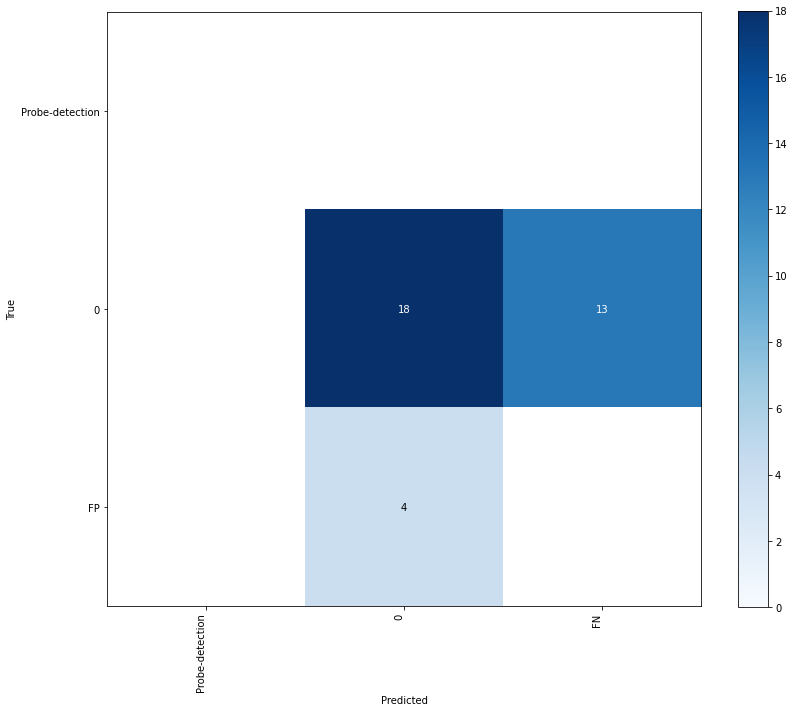

In [29]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_test.classes
)

_ = confusion_matrix.plot()

## Save fine-tuned model on hard drive

In [30]:
model.save_pretrained(datasets_path+"/rt-detr/")
processor.save_pretrained(datasets_path+"/rt-detr/")

['/home/cjs/Documents/Probe-Detection-Using-Deep-Learning/notebook/data/probe_preprocessed_RT-DETR/rt-detr/preprocessor_config.json']

## Inference with fine-tuned RT-DETR model

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBox

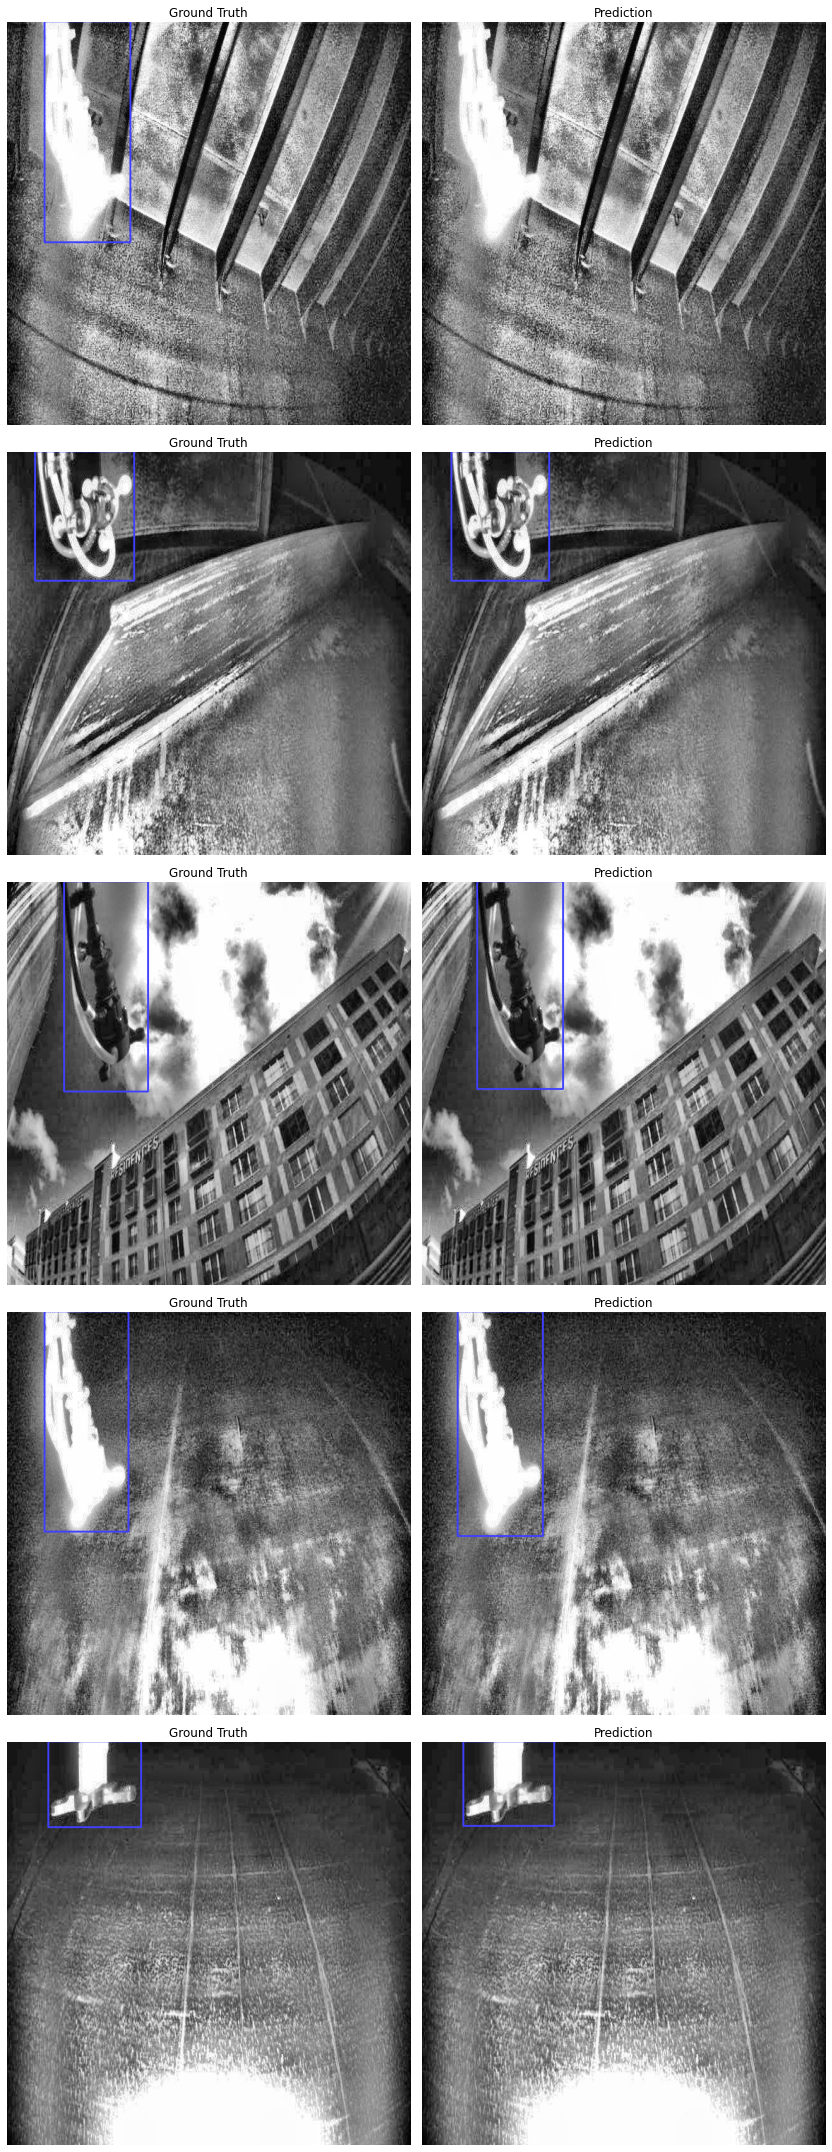

Average Preprocessing Time: 0.0068 seconds
Average Inference Time: 0.0095 seconds
Average Loss Time: 0.0000 seconds
Average Postprocessing Time: 0.0006 seconds


In [42]:
import matplotlib.pyplot as plt

IMAGE_COUNT = 5

# Initialize lists to store timings for each parameter
preprocess_times = []
inference_times = []
loss_times = []  # If loss is applicable, otherwise it can remain zero
postprocess_times = []

annotated_images = []  # Store all annotated images for final combined plot

for i in range(IMAGE_COUNT):
    path, source_image, annotations = ds_test[i]

    # Measure Preprocessing Time
    start_time = time.time()
    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)
    preprocess_times.append(time.time() - start_time)

    # Measure Inference Time
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    inference_times.append(time.time() - start_time)

    # Measure Loss Time (if applicable, otherwise set to zero)
    start_time = time.time()
    loss_times.append(0)  # Replace with actual loss calculation time if relevant

    # Measure Postprocessing Time
    start_time = time.time()
    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3
    )
    detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)
    postprocess_times.append(time.time() - start_time)

    # Annotate images
    annotated_images.extend([
        annotate(source_image, annotations, ds_train.classes),  # Ground truth
        annotate(source_image, detections, ds_train.classes)    # Predictions
    ])

# Create a combined plot with 10 images (5 ground truths + 5 predictions)
fig, axes = plt.subplots(5, 2, figsize=(12, 30))  # 5 rows, 2 columns
axes = axes.flatten()  # Flatten the axes array for easy iteration

for idx, (ax, img) in enumerate(zip(axes, annotated_images)):
    ax.imshow(img)
    ax.axis('off')
    title = "Ground Truth" if idx % 2 == 0 else "Prediction"
    ax.set_title(title, fontsize=12)

plt.tight_layout()
plt.show()

# Calculate average times
average_preprocess = sum(preprocess_times) / len(preprocess_times)
average_inference = sum(inference_times) / len(inference_times)
average_loss = sum(loss_times) / len(loss_times)
average_postprocess = sum(postprocess_times) / len(postprocess_times)

# Print results
print(f"Average Preprocessing Time: {average_preprocess:.4f} seconds")
print(f"Average Inference Time: {average_inference:.4f} seconds")
print(f"Average Loss Time: {average_loss:.4f} seconds")
print(f"Average Postprocessing Time: {average_postprocess:.4f} seconds")
